<center>

## **Music Genre <span style="color:rgb(255, 0, 0);">Detection.</span>**
**Presented by Hardik (019) & Prabal (035**)

</center>

---


In [7]:
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, classification_report
from lazypredict.Supervised import LazyClassifier  # Import LazyPredict

### **Step 1: Loading dataset <span style="color: yellow;">&</span> Extracting audio features.**

**`extract_features` function:**
- Loading with `librosa.load`: This function reads the audio file and returns the audio signal and sampling rate.
---

**MFCC (Mel Frequency Cepstral Coefficients)** - are features that represent the short-term power spectrum of sound.

**Why MFCC ? `librosa.feature.mfcc`**
- They approximate the human auditory system’s response, focusing on perceptually meaningful frequency bands.
- They provide a compact representation of the spectral properties of audio.
- This makes them very effective in tasks such as speech and music recognition.

---

**Chroma STFT (Short-Time Fourier Transform):** - Chroma features represent the energy distribution across the 12 pitch classes (semitones) of the musical octave.

**Why Chroma STFT?`librosa.feature.chroma_stft`**
- Chroma features are robust to changes in timbre and instrumentation, making them useful for tasks like chord recognition and key detection.
- They capture harmonic and melodic characteristics of music, which are crucial for genre classification.

---

**Spectral Contrast:** - Spectral contrast measures the difference in amplitude between peaks and valleys in the frequency spectrum.

**Why Spectral Contrast?`librosa.feature.spectral_contrast`**
- It captures the richness and dynamics of the audio signal, which are important for distinguishing between different genres.
- It is particularly effective in identifying percussive and harmonic elements in music.

---


In [ ]:
GENRE_PATH = "genres"
OUTPUT_CSV = "data.csv"

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        return np.hstack([mfcc, chroma, spectral_contrast])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

data = []
genres = []

for genre in os.listdir(GENRE_PATH):
    genre_path = os.path.join(GENRE_PATH, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                genres.append(genre)

df = pd.DataFrame(data)
df["genre"] = genres
df.to_csv(OUTPUT_CSV, index=False)
print("Feature extraction completed and saved to", OUTPUT_CSV)


### **Step 2: Genre wise <span style="color: green;">EDA</span> of extracted audio features.**

To understand the distribution of audio features across the top 4 most frequent genres in the dataset.

- **Box Plots** are created for the first 31 audio features to visualize their distribution across the top 4 genres.
- The plots help us understand the variability and range of each feature for different genres.

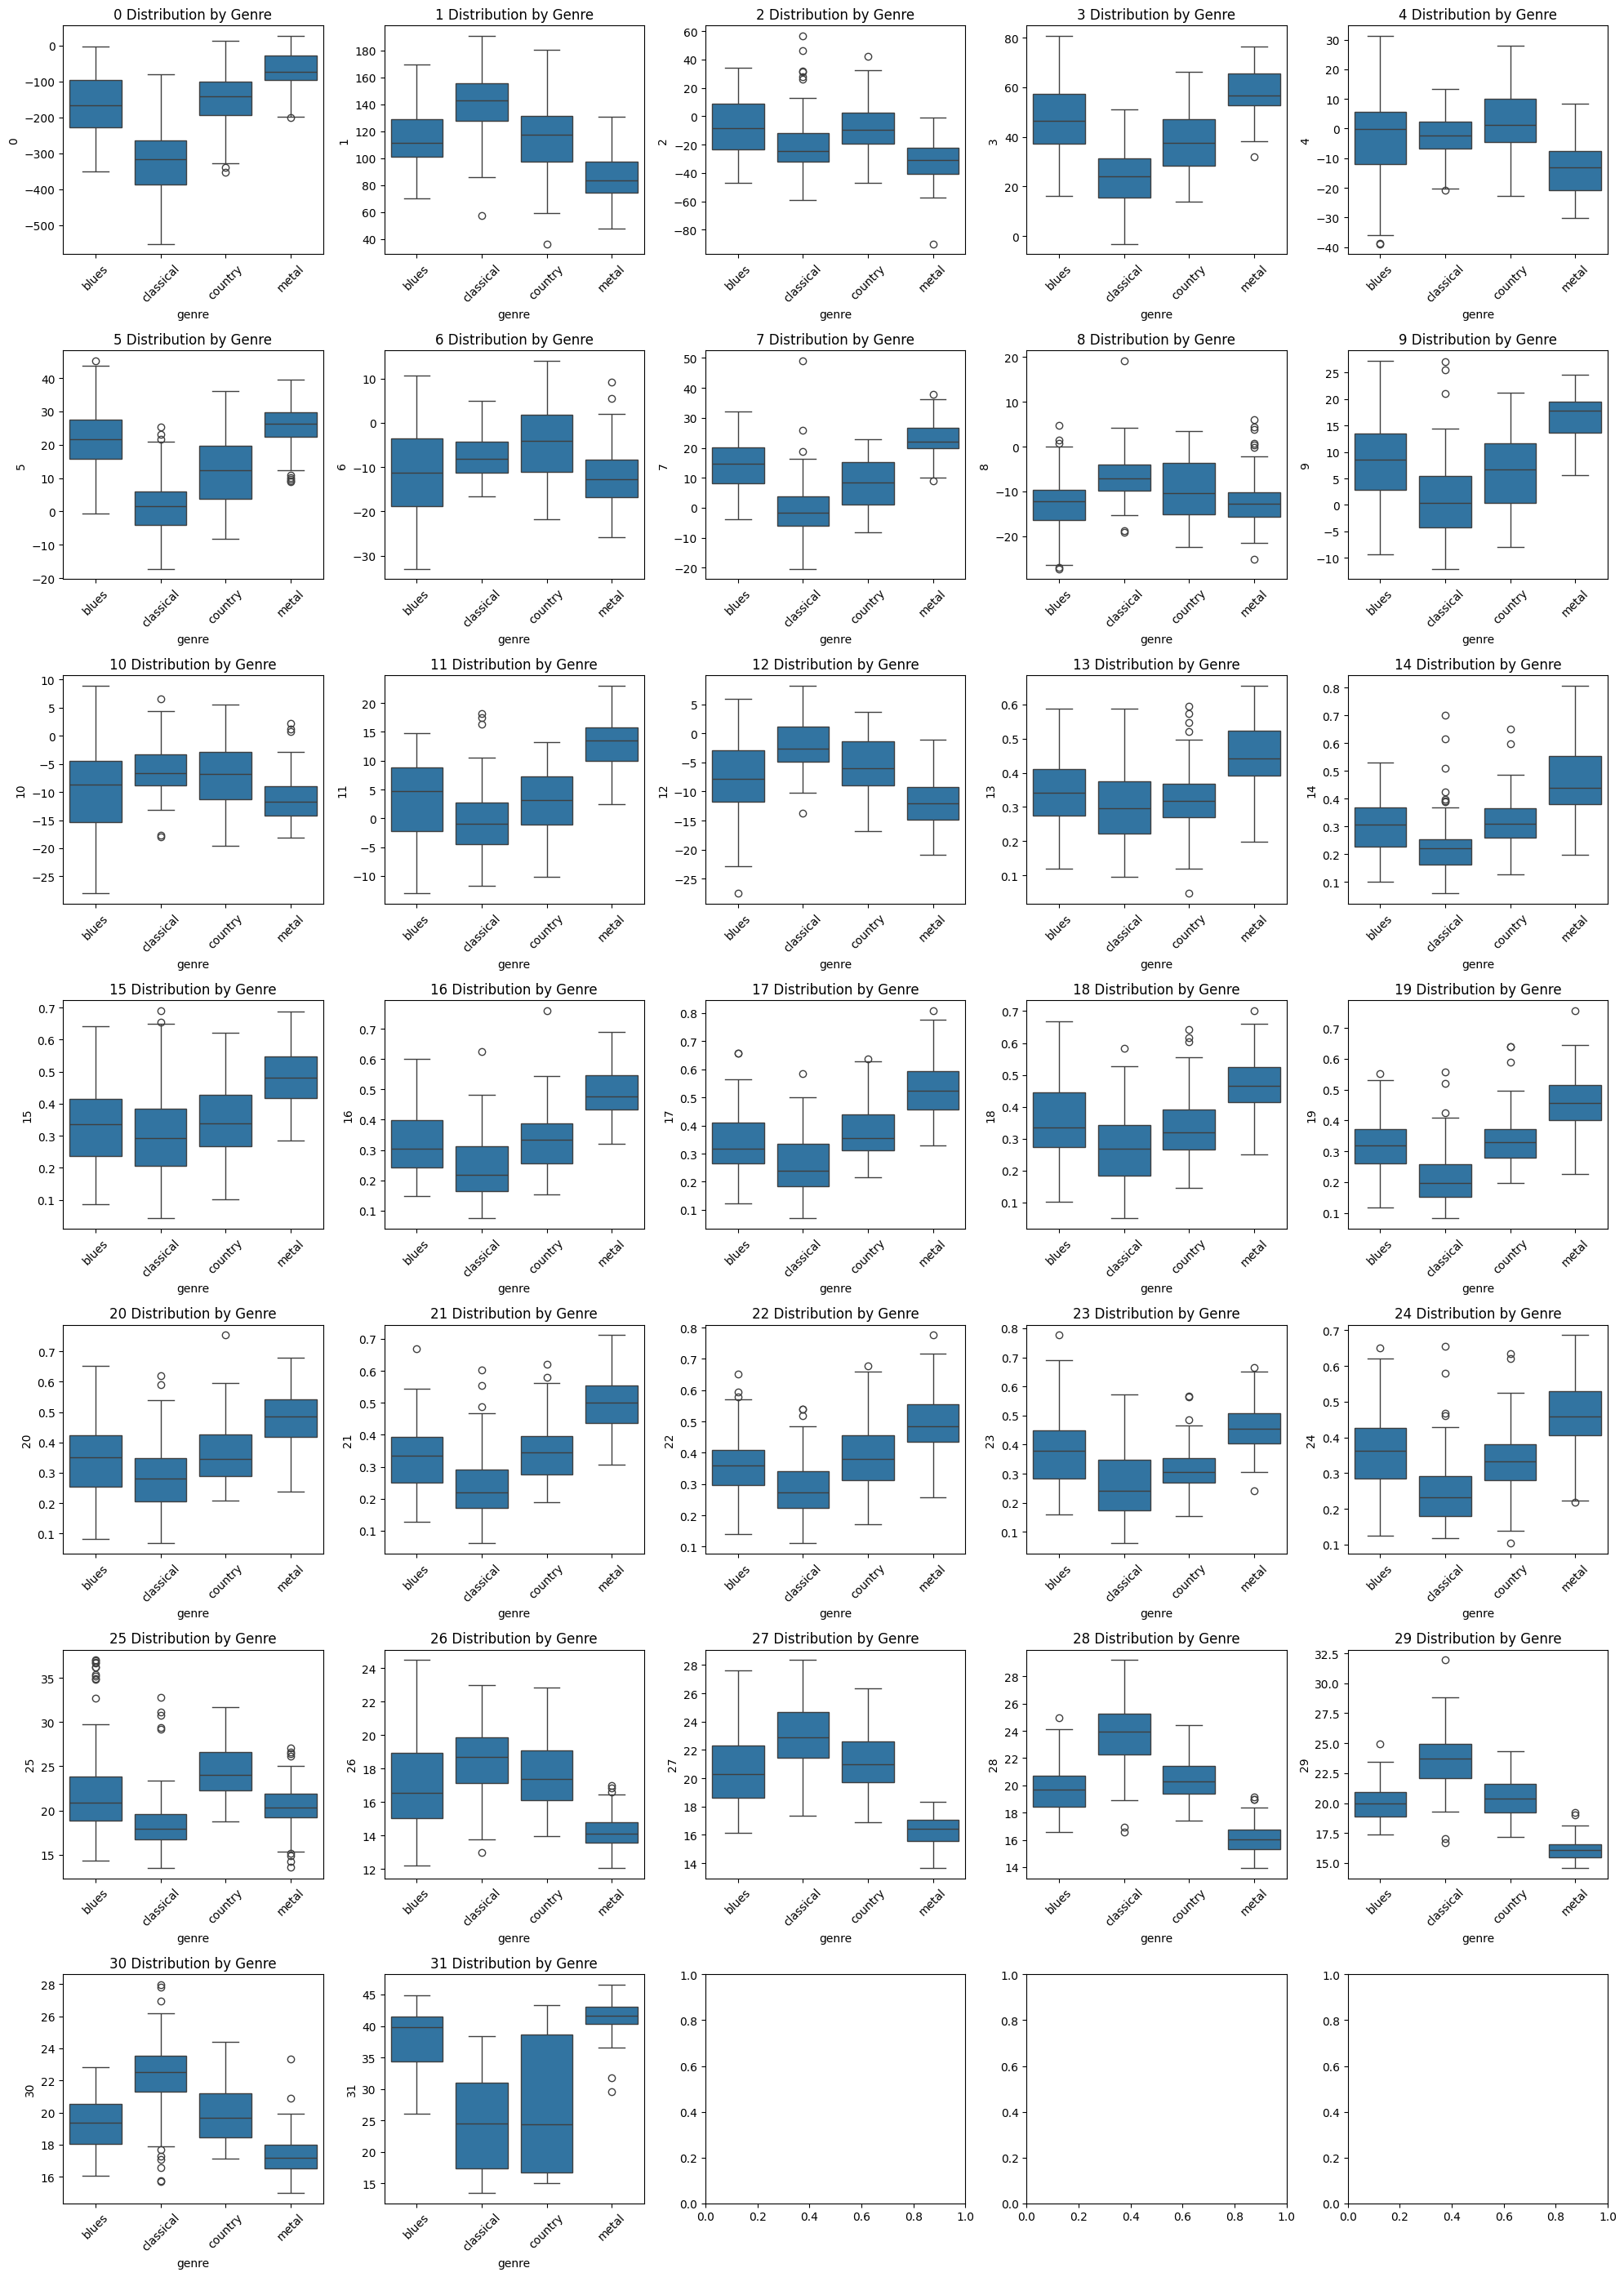

In [ ]:

# Data loading
df = pd.read_csv('data.csv')

# Data exploration (finding top 4 genres)
genre_counts = df['genre'].value_counts()
top_4_genres = genre_counts.head(4).index.tolist()

# Data wrangling (filtering for top 4 genres)
df_filtered = df[df['genre'].isin(top_4_genres)]

# Data visualization (box plots)
num_cols = len(df_filtered.columns[:31])  # Get the number of columns to plot
num_rows = (num_cols + 4) // 5  # Calculate the number of rows needed, ensuring 5 columns

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, num_rows * 4))  # Adjust figsize dynamically
axes = axes.flatten()

for i, col in enumerate(df_filtered.columns[:32]):
    sns.boxplot(x='genre', y=col, data=df_filtered, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by Genre')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

plt.tight_layout()
plt.show()

### **Step 3 : <span style="color:rgb(213, 88, 203);">Training KNN classifier.</span>**


#### **Why KNN?**
- KNN is a simple yet powerful algorithm for classification tasks.
- It works well for datasets where the relationship between features and labels is non-linear.


---
**Encoding Genre Labels:**
- The genre labels are encoded into numerical values using `LabelEncoder`.
- This step is necessary because machine learning models work with numerical data.

**Feature Normalization:**
- The features are normalized using `StandardScaler` to ensure all features have a mean of 0 and a standard deviation of 1.
- Normalization improves the performance of distance-based algorithms like KNN.

**Train/Test Split:**
- The dataset is split into training and testing sets using an 80-20 split.
- This ensures the model is evaluated on unseen data.

**Finding the Optimal Value of `k`:**
- A range of `k` values (from 1 to 20) is tested using **K-Fold Cross-Validation** (5 folds).
- For each `k`, the model's accuracy is evaluated, and the average accuracy across folds is calculated.
- The value of `k` with the highest accuracy is selected as the optimal value.

**Training the Model:** The KNN model is trained using the optimal value of `k`.

**Cross-Validation:** Ensures the model's performance is robust and not overfitted to the training data.

**Optimal `k`:** The value of `k` is chosen based on the highest cross-validation accuracy.



In [10]:

DATA_CSV = "data.csv"
MODEL_FILE = "knn_model.pkl"

# Load the dataset
df = pd.read_csv(DATA_CSV)
X = df.iloc[:, :-1].values
y = df["genre"].values

# Encode genre labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the range of k values to test
k_values = range(1, 21)  # Testing k from 1 to 20
best_k = 1
best_accuracy = 0

# Perform K-Fold Cross-Validation to find the best k value
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')  # Cross-validation for each k
    avg_accuracy = np.mean(cv_scores)  # Average accuracy across folds

    #print(f"K={k}, Cross-Validation Accuracy: {avg_accuracy:.2f}")

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = k

#print(f"Optimal value of k: {best_k} with an average cross-validation accuracy of {best_accuracy:.2f}")

# Train the model with the best k
knn_optimal = KNeighborsClassifier(n_neighbors=best_k)
knn_optimal.fit(X_train, y_train)

# Test accuracy
accuracy = knn_optimal.score(X_test, y_test)
print(f"Model trained with optimal k={best_k} and accuracy on test set: {accuracy:.2f}")


Model trained with optimal k=3 and accuracy on test set: 0.86



---
### **Step 4 : <span style="color:rgb(213, 88, 203);">Model benchmarking.</span>**



**LazyPredict** is a Python library that quickly trains and evaluates multiple machine learning models without writing individual model code.  
It helps in **model benchmarking** by running multiple classifiers on your dataset and returning their performance metrics.  

## 🔹 How It Works?  
Instead of manually training models like **SVM, Decision Trees, or Random Forest**, `LazyClassifier` does this automatically:  

1. **Splits your dataset** into training and testing sets.  
2. **Trains multiple classifiers** (like Logistic Regression, SVM, Random Forest, etc.).  
3. **Evaluates models** on:
   **Accuracy ,**
   **F1-score ,**
   **Recall ,**
   **Precision ,**
   **Training time**  
4. **Returns a sorted table** of models based on performance.  

---




In [11]:
DATA_CSV = "data.csv"


# Load dataset
df = pd.read_csv(DATA_CSV)
X = df.iloc[:, :-1].values
y = df["genre"].values

# Encode genre labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyClassifier and fit on the dataset
clf = LazyClassifier()
models, _ = clf.fit(X_train, X_test, y_train, y_test)

# Show results of all models
print(models)

# From here, you can choose the best model and proceed with training it on the full training data
best_model_name = models.index[0]  # The best model according to LazyPredict
best_model = models.loc[best_model_name]

  0%|          | 0/32 [00:00<?, ?it/s]

 97%|█████████▋| 31/32 [00:01<00:00, 18.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 32
[LightGBM] [Info] Start training from score -1.464256
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

100%|██████████| 32/32 [00:01<00:00, 16.64it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
CalibratedClassifierCV             0.94               0.94    None      0.94   
LinearDiscriminantAnalysis         0.94               0.93    None      0.94   
ExtraTreesClassifier               0.91               0.92    None      0.91   
Perceptron                         0.91               0.92    None      0.91   
RidgeClassifier                    0.91               0.91    None      0.91   
SVC                                0.90               0.91    None      0.90   
LogisticRegression                 0.90               0.90    None      0.90   
LinearSVC                          0.90               0.90    None      0.90   
RidgeClassifierCV                  0.90               0.90    None      0.90   
XGBClassifier                      0.89               0.88    None      0.89   
KNeighborsClassifier               0.88 

### **Step 5 : <span style="color:rgb(213, 88, 203);">Training CalibratedClassifierCV Model & it's evaluation.</span>**


**What is SVM (Support Vector Machine)?**
- Support Vector Machine (SVM) is a supervised learning algorithm mainly used for classification and regression tasks.
- It is particularly effective for high-dimensional datasets and works by finding the <span style="color: yellow;">optimal decision boundary (hyperplane)</span>  that best separates different classes.

SVM is based on the concept of maximizing the margin between data points of different classes.\
It identifies the support vectors, which are the most important data points that define the hyperplane.

---
**SVM is used here because:**
- It works well with high-dimensional data (e.g., extracted audio features).
- It is robust to noise and effective even with small datasets.
- It provides a clear decision boundary for classification.


**Why is this important for SVM?**
- SVM is sensitive to feature scales – If one feature has a much larger scale than another, it can dominate the model, leading to poor performance.
- Improves convergence speed – Scaling helps in faster training of the SVM model.
- Avoids biased hyperplane placement – Without scaling, features with larger values might skew the decision boundary.

#### **Support Vector Classifier (SVC)**
- **SVC** is chosen as the base model for classification.
- The `probability=True` parameter is set to enable probability calibration.

---

#### **CalibratedClassifierCV**
- **Why Calibration?**
    - SVC does not provide well-calibrated probabilities by default.
    - **`CalibratedClassifierCV`** adjusts the probabilities using a sigmoid function, making them more reliable.
- The SVC model is first trained on the training data.
- The calibrated classifier is then fitted using the trained SVC model.


  0%|          | 0/32 [00:00<?, ?it/s]

 97%|█████████▋| 31/32 [00:01<00:00, 16.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 32
[LightGBM] [Info] Start training from score -1.464256
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Info] Start training from score -1.361602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

100%|██████████| 32/32 [00:02<00:00, 14.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

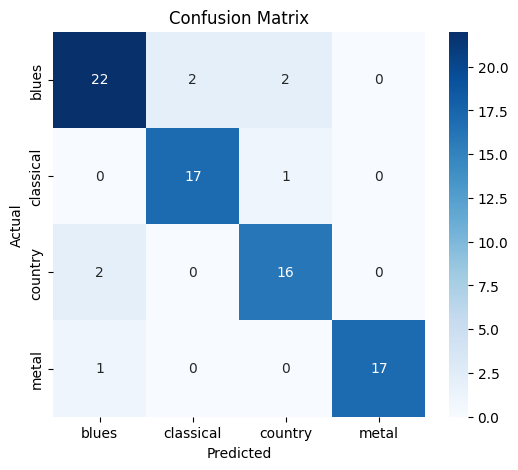

Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.85      0.86        26
   classical       0.89      0.94      0.92        18
     country       0.84      0.89      0.86        18
       metal       1.00      0.94      0.97        18

    accuracy                           0.90        80
   macro avg       0.90      0.91      0.90        80
weighted avg       0.90      0.90      0.90        80



In [13]:
DATA_CSV = "data.csv"
#MODEL_FILE = "calibrated_svc_model.pkl"

# Load dataset
df = pd.read_csv(DATA_CSV)
X = df.iloc[:, :-1].values
y = df["genre"].values

# Encode genre labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyClassifier and fit on the dataset
clf = LazyClassifier()
models, _ = clf.fit(X_train, X_test, y_train, y_test)

# Show results of all models

# Use Support Vector Classifier (SVC) as the base model
svc = SVC(probability=True, random_state=42)  # Ensure probability=True to use CalibratedClassifierCV

# Apply CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv='prefit')

# Fit the base model first
svc.fit(X_train, y_train)

# Calibrate the classifier
calibrated_svc.fit(X_train, y_train)

# Save the calibrated model and other components

# Test accuracy
accuracy = calibrated_svc.score(X_test, y_test)
print(f"Calibrated SVC model trained with accuracy: {accuracy:.2f}")

# Generate predictions
y_pred = calibrated_svc.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert numerical labels back to genre names
genre_labels = encoder.classes_

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=genre_labels))

# Save the calibrated model, encoder, and scaler


**Accuracy Score:**
- This metric measures the ratio of correct predictions to the total number of predictions.
- It is a common and straightforward metric when classes are balanced.

**Why accuracy instead of precision, recall, or F1 score?**
- In many projects, if the dataset is relatively balanced (i.e., each class has roughly the same number of samples), accuracy provides a clear overall performance metric.
- **Precision, recall, and F1** are particularly useful in **imbalanced datasets or when the costs of false positives and false negatives** are very different.

Accuracy is easier to interpret for a quick performance check.